In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def json_dump(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f)
        
def q_error(actual, pred):
    epsilon = 1e-4
    q_e = 0
    for i in range(len(pred)):
        q_e += max((actual[i]+epsilon)/(pred[i]+epsilon),(pred[i]+epsilon)/(actual[i]+epsilon))
    return q_e/len(pred)

In [2]:
import ast
import re
from collections import OrderedDict
from selection.data_preparation import read_csv, index_conversion
from selection.workload import Query, Index, Column, Table

In [3]:
TPC_DS_TABLE_PREFIX = {
    "dv": "dbgen_version",
    "ca": "customer_address",
    "cd": "customer_demographics",
    "d": "date_dim",
    "w": "warehouse",
    "sm": "ship_mode",
    "t": "time_dim",
    "r": "reason",
    "ib": "income_band",
    "i": "item",
    "s": "store",
    "cc": "call_center",
    "c": "customer",
    "web": "web_site",
    "sr": "store_returns",
    "hd": "household_demographics",
    "wp": "web_page",
    "p": "promotion",
    "cp": "catalog_page",
    "inv": "inventory",
    "cr": "catalog_returns",
    "wr": "web_returns",
    "ws": "web_sales",
    "cs": "catalog_sales",
    "ss": "store_sales"
}

TPC_H_TABLE_PREFIX = {
    "n": "nation",
    "r": "region",
    "p": "part",
    "s": "supplier",
    "ps": "partsupp",
    "c": "customer",
    "o": "orders",
    "l": "lineitem",
}

In [4]:
def read_table_info(row_info_filepath, column_info_filepath):
    data_table_info = read_csv(row_info_filepath)[2:-2]
    table_dict = OrderedDict()
    for table_info in data_table_info:
        table_info_tuple = table_info[0].split('|')
        if len(table_info_tuple) < 2: continue
        table_name = table_info_tuple[0].strip()
        row_count = float(table_info_tuple[1].strip())
        table = Table(table_name)
        table.set_row_count(row_count)
        table_dict[table_name] = table
        
    TABLE_PREFIX_MAP = None
    if re.search("TPC_DS", column_info_filepath):
        TABLE_PREFIX_MAP = TPC_DS_TABLE_PREFIX
    elif re.search("TPCH", column_info_filepath):
        TABLE_PREFIX_MAP = TPC_H_TABLE_PREFIX
    else: raise ValueError("Specified dataset not supported")
    
    data_column_info = read_csv(column_info_filepath)[2:-2]
    column_dict = {}
    for column_info in data_column_info:
        column_info_tuple = column_info[0].split('|')
        if len(column_info_tuple) < 3: continue
        column_name = column_info_tuple[0].strip()
        null_frac = float(column_info_tuple[1].strip())
        n_distinct = float(column_info_tuple[2].strip())
        column = Column(column_name)
        column.set_cardinality(-n_distinct * row_count if n_distinct < 0 else n_distinct)
        column.set_null_fraction(null_frac)
        if (prefix := column_name.split('_')[0]) in TABLE_PREFIX_MAP.keys():
            table_name = TABLE_PREFIX_MAP[prefix]
            if table_name in table_dict.keys():
                column.table = table_dict[table_name]
                column.table.add_column(column)      
        column_dict[column_name] = column
    return table_dict, column_dict


table_dict_DS_50G, column_dict_DS_50G = read_table_info("../data/TPC_DS_50G/tpcds50trow.csv", "../data/TPC_DS_50G/tpcds50stats.csv")
table_dict_DS_10G, column_dict_DS_10G = read_table_info("../data/TPC_DS_10G/tpcds10trow.csv", "../data/TPC_DS_10G/tpcds10stats.csv")
table_dict_H, column_dict_H = read_table_info("../data/TPCH/tpchtrow.csv", "../data/TPCH/tpchstats.csv")

In [5]:
len(table_dict_DS_50G), len(table_dict_DS_10G), len(table_dict_H)

(25, 25, 8)

In [6]:
def convert_configuration_to_obj(columns_dict, confg_string):
    configs = []
    for config_s in confg_string:
        if config_s == "[]": 
            configs.append([])
            continue
        config = []
        indexes_s = config_s.split('I')
        for index_s in indexes_s:
            if index_s == '': continue
            table_columns = index_s.split('C')
            indexed_columns = []
            for table_column in table_columns:
                table_column = table_column.strip('(), ')
                if table_column == '': continue
                column_name = table_column.split('.')[-1]
                if column_name in columns_dict:
                    indexed_columns.append(columns_dict[column_name])
            config.append(Index(indexed_columns))
        configs.append(config)
    return configs

In [7]:
def read_query_and_index_data(filepath, column_dict):
    # data_list[i][0]: Query ID and Query text for the i-th query
    # data_list[i][1]: Index configurations for the i-th query
    # data_list[i][2]: Average cost of each configuration for the i-th query
    # data_list[i][3]: Query execution plan of each configuration for the i-th query
    # data_list[i][4]: Details execution costs (each query is executed 4 times and the last 3 times are recorded) of each configuration for the i-th query

    data_list_string = read_csv(filepath)
    data, queries = [], []
    for i in range(len(data_list_string)):
        data_list_string[i][0] = ast.literal_eval(data_list_string[i][0])
        query = Query(data_list_string[i][0][0], data_list_string[i][0][1])
        query.columns = [column for column_name, column in column_dict.items() if column_name in query.text]
        queries.append(query)
        indexes_string = index_conversion(data_list_string[i][1])
        index_configurations = convert_configuration_to_obj(column_dict, indexes_string)
        average_costs = ast.literal_eval(data_list_string[i][2])
        plans = ast.literal_eval(data_list_string[i][3])
        queries.append(query)
        data.append([query, index_configurations, average_costs, plans])
    return data, queries

DS_50G_data, _ = read_query_and_index_data("../data/TPC_DS_50G/TPC_DS_50GB.csv", column_dict_DS_50G)
DS_10G_data, _ = read_query_and_index_data("../data/TPC_DS_10G/TPC_DS_10GB.csv", column_dict_DS_10G)
H_data, _ = read_query_and_index_data("../data/TPCH/TPC_H_10.csv", column_dict_H)

### Index Filter

#### Labels

In [8]:
PHYISCAL_TO_LOGICAL_OPERATOR_MAP = {
    "Seq Scan": "Scan",
    "Bitmap Index Scan": "Scan",
    "Bitmap Heap Scan": "Scan",
    "Index Scan": "Scan",
    "Index Only Scan": "Scan",
    "CTE Scan": "Scan",
    "Subquery Scan": "Scan",
    "Sort": "Sort",
    "Incremental Sort": "Sort",
    "Hash Join": "Join",
    "Merge Join": "Join",
    "Nested Loop": "Join",
    "Aggregate": "Aggregate",
    "WindowAgg": "Aggregate",
    "Group": "Aggregate",
    "Gather Merge": "",
    "Gather": "",
    "BitmapOr": "",
    "BitmapAnd": "",
    "Limit": "",
    "Hash": "",
    "Result": "",
    "SetOp": "",
    "Append": "",
    "Materialize": "",
    "Unique": "",
    "Merge Append": "",
    
}

LOGICAL_OPERATORS = ["Scan", "Join", "Aggregate", "Sort"]

In [9]:
def has_child_node(query_plan):
    return "Plans" in query_plan.keys()

def has_filtering_property(query_plan):
    if "Filter" in query_plan.keys():
        return query_plan["Filter"]
    if "Hash Cond" in query_plan.keys():
        return query_plan["Hash Cond"]
    if "Join Filter" in query_plan.keys():
        return query_plan["Join Filter"]
    return ""

def is_join_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Join"

def is_sort_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Sort"

def is_aggregate_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Aggregate"

def is_scan_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Scan"

def check_indexed_column_in_condition(index, condition):
    for column in index.columns:
        if column.name in condition:
            return True

def get_table_from_plan_node(query_plan):
    table = ""
    if "Relation Name" in query_plan.keys():
        table = query_plan["Relation Name"]
    return table

In [10]:
physical_operators = set()

def collect_physical_operators(physical_operators, query_plan): 
    physical_operators.add(query_plan["Node Type"])
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            collect_physical_operators(physical_operators, child_node)
            
# for _, query_plan in query_plans_with_index.items():
#     collect_physical_operators(physical_operators, query_plan) 

for sample in DS_50G_data:
    query_plans = sample[3]
    for query_plan in query_plans:
        collect_physical_operators(physical_operators, query_plan)

physical_operators = list(physical_operators)  
print(physical_operators)

['Nested Loop', 'Seq Scan', 'Append', 'BitmapOr', 'Hash Join', 'BitmapAnd', 'Subquery Scan', 'Sort', 'CTE Scan', 'SetOp', 'Gather Merge', 'WindowAgg', 'Bitmap Index Scan', 'Unique', 'Merge Join', 'Incremental Sort', 'Merge Append', 'Index Only Scan', 'Index Scan', 'Group', 'Hash', 'Bitmap Heap Scan', 'Result', 'Gather', 'Aggregate', 'Limit', 'Materialize']


#### Feautures

In [11]:
# signal 1
def estimate_index_utility(index, original_query_plan, indexed_query_plan):
    total_cost = 0
    if has_child_node(original_query_plan):
        for original_child_node, indexed_child_node in zip(indexed_query_plan["Plans"], indexed_query_plan["Plans"]):
            total_cost += estimate_index_utility(index, original_child_node, indexed_child_node)
    current_operator = indexed_query_plan["Node Type"]
    current_cost = original_query_plan["Total Cost"]
    if (condition := has_filtering_property(indexed_query_plan)) != "":
        if is_join_operator(current_operator):
            join_output_rows = indexed_query_plan["Plan Rows"]
            left_input_rows = indexed_query_plan["Plans"][0]["Plan Rows"]
            right_input_rows = indexed_query_plan["Plans"][1]["Plan Rows"]
            if check_indexed_column_in_condition(index, condition):    
                current_cost = (1-np.sqrt(join_output_rows/(left_input_rows*right_input_rows)))*original_query_plan["Total Cost"]
        else:
            selectivities = [indexed_query_plan["Plan Rows"]/column.table.row_count for column in index.columns if column.name in condition]
            average_selectivity = sum(selectivities)/len(selectivities) if len(selectivities) > 0 else 0
            current_cost = (1-average_selectivity)*original_query_plan["Total Cost"]
    elif is_sort_operator(current_operator) and "Sort Key" in indexed_query_plan.keys():
        sort_conditions = indexed_query_plan["Sort Key"]
        for sort_condition in sort_conditions:
            if check_indexed_column_in_condition(index, sort_condition):
                current_cost = indexed_query_plan["Total Cost"]
    elif is_aggregate_operator(current_operator) and "Group Key" in indexed_query_plan.keys():
        group_conditions = indexed_query_plan["Group Key"]
        for group_condition in group_conditions:
            if check_indexed_column_in_condition(index, group_condition):
                current_cost = indexed_query_plan["Total Cost"]
    return total_cost+current_cost

In [12]:
# signal 2
def extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan):
    query_shape, index_shape = {}, []
    _extract_query_shape(query_shape, original_query_plan)
    visited = set()
    _extract_index_shape(index_shape, index, indexed_query_plan, visited)
    return query_shape, index_shape

def _extract_query_shape(query_shape, query_plan):
    current_operator = query_plan["Node Type"]
    logical_operator = PHYISCAL_TO_LOGICAL_OPERATOR_MAP[current_operator]
    if is_scan_operator(current_operator):
        table = get_table_from_plan_node(query_plan)
        if table in query_shape.keys():
            query_shape[table].append(logical_operator)
        else:
            query_shape[table] = [logical_operator]
        return table
    
    tables = []    
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            table = _extract_query_shape(query_shape, child_node)
            if table and logical_operator:
                tables.append(table)
                query_shape[table].append(logical_operator)
    return tables[0] if 0<len(tables)<2 else ""

def _extract_index_shape(index_shape, index, query_plan, visited):
    current_operator = query_plan["Node Type"]
    logical_operator = PHYISCAL_TO_LOGICAL_OPERATOR_MAP[current_operator]
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _extract_index_shape(index_shape, index, child_node, visited)
            
    if (condition := has_filtering_property(query_plan)) != "":
        for column in index.columns:
            if column in visited: continue
            elif column.name in condition:
                index_shape.append(logical_operator)
                visited.add(column)
    elif is_sort_operator(current_operator) and "Sort Key" in query_plan.keys():
        sort_conditions = query_plan["Sort Key"]
        for sort_condition in sort_conditions:
            for column in index.columns:
                if column in visited: continue
                elif column.name in sort_condition:
                    index_shape.append(logical_operator)
                    visited.add(column)
    elif is_aggregate_operator(current_operator) and "Group Key" in query_plan.keys():
        aggregate_conditions = query_plan["Group Key"]
        for aggregate_condition in aggregate_conditions:
            for column in index.columns:
                if column in visited: continue
                elif column.name in aggregate_condition:
                    index_shape.append(logical_operator)
                    visited.add(column)

In [13]:
# signal 3
def evaluate_operator_relevance(index, query_plan):
    result = {}
    _evaluate_operator_relevance(result, index, query_plan)
    return result

def _evaluate_operator_relevance(operator_relevance, index, query_plan):
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _evaluate_operator_relevance(operator_relevance, index, child_node)
            
    current_operator = query_plan["Node Type"]
    relevance = 0
    if (condition := has_filtering_property(query_plan)) != "":
        selectivities = [query_plan["Plan Rows"]/column.table.row_count for column in index.columns if column.name in condition]
        relevance = sum(selectivities)/len(selectivities) if len(selectivities) > 0 else 0
    elif is_sort_operator(current_operator) and "Sort Key" in query_plan.keys():
        densities = []
        conditions = query_plan["Sort Key"]
        for condition in conditions:
            for column in index.columns:
                if column.name in condition:
                    densities.append(column.cardinality/column.table.row_count)
        relevance = sum(densities)/len(densities) if len(densities) > 0 else 0
    elif is_aggregate_operator(current_operator) and "Group Key" in query_plan.keys():
        densities = []
        conditions = query_plan["Group Key"]
        for condition in conditions:
            for column in index.columns:
                if column.name in condition:
                    densities.append(column.cardinality/column.table.row_count)
        relevance = sum(densities)/len(densities) if len(densities) > 0 else 0
    if current_operator not in operator_relevance: 
        operator_relevance[current_operator] = []
    operator_relevance[current_operator].append(relevance)

In [14]:
# signal 4
def get_number_of_pages(query_plan):
    return query_plan["Shared Hit Blocks"] + query_plan["Shared Read Blocks"] + query_plan["Local Hit Blocks"] + query_plan["Local Read Blocks"]

# check primary key instead
# not used
def count_clustered_index(db_connector, table_name):
    count = db_connector.count_clustered_indexes(table_name)
    return count

def check_bitmap(query_plan):
    current_operator = query_plan["Node Type"]
    use = False
    if is_scan_operator(current_operator):
        use = "Bitmap" in current_operator
    
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            use |= check_bitmap(child_node)
    return use

In [15]:
MAX_TABLE_NUM = 25
def construct_features_and_labels(data, table_dict):
    labels = []
    feature_columns = ["utility", "num_pages", "use_bitmap"]
    operator_relevance_columns = [f"relevance_{operator}" for operator in LOGICAL_OPERATORS]
    feature_columns.extend(operator_relevance_columns)
    query_shape_columns = [f"query_shape_operator{i}_on_table{j}" for j in range(MAX_TABLE_NUM+1) for i in range(5)]
    feature_columns.extend(query_shape_columns)
    index_shape_columns = [f"index_shape_operator{i}" for i in range(5)]
    feature_columns.extend(index_shape_columns)

    single_index_query_ids = [(i,j) for i, entry in enumerate(data) for j, config in enumerate(entry[1]) if len(config) == 1]
    features = pd.DataFrame(columns=feature_columns, index=range(len(single_index_query_ids)))

    for k, (i,j) in enumerate(single_index_query_ids):
        query = data[i][0]
        index_configs = data[i][1]
        costs = data[i][2]
        plans = data[i][3]
        
        # only consider single index config
        index = index_configs[j][0]
        labels.append(costs[j])
        original_query_plan = plans[0] # no indexed query plan
        original_query_cost = costs[0] # no index query cost
        indexed_query_plan = plans[j]
        utility = estimate_index_utility(index, original_query_plan, indexed_query_plan)/original_query_cost
        query_shape, index_shape = extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan)
        table_keys = [table_key for table_key,_ in table_dict.items()]
        for table, operator_seq in query_shape.items():
            for j, operator in enumerate(operator_seq):
                if table in table_keys:
                    table_index = table_keys.index(table)
                    features.iloc[k][f"query_shape_operator{j}_on_{table_index}"] = operator
        for j, operator in enumerate(index_shape):
            features.iloc[k][f"index_shape_operator{j}"] = operator
        relevance = evaluate_operator_relevance(index, original_query_plan)
        for operator in LOGICAL_OPERATORS:
            if operator in relevance: features.iloc[k][f"relevance_{operator}"] = sum(relevance[operator])/len(relevance[operator])
            else: features.iloc[k][f"relevance_{operator}"] = 0
        num_pages = get_number_of_pages(indexed_query_plan)
        use_bitmap = check_bitmap(indexed_query_plan)
        features.iloc[k]["utility"] = utility
        features.iloc[k]["num_pages"] = num_pages
        features.iloc[k]["use_bitmap"] = int(use_bitmap)
        
    features[["utility", "num_pages"]+operator_relevance_columns] = features[["utility", "num_pages"]+operator_relevance_columns].apply(pd.to_numeric)
    features["use_bitmap"] = features["use_bitmap"].astype('int')
    
    return features, labels



features_DS_50G, labels_DS_50G = construct_features_and_labels(DS_50G_data, table_dict_DS_50G)
features_DS_10G, labels_DS_10G = construct_features_and_labels(DS_10G_data, table_dict_DS_10G)
features_H, labels_H = construct_features_and_labels(H_data, table_dict_H)
print("labels:\n", labels_DS_10G)
features_DS_10G

labels:
 [3821.840666666667, 16285.343666666668, 117.93266666666666, 6416.822666666667, 6354.952333333334, 6355.659666666666, 6457.203666666665, 6407.342666666666, 6349.016333333333, 6415.018666666667, 6649.308666666667, 4284.687999999999, 4400.314333333333, 4409.274666666667, 4306.645, 2499.605666666667, 2430.9223333333334, 1219.0106666666668, 148.68966666666668, 518.3246666666666, 493.834, 2563.286, 2632.2236666666663, 2532.9833333333336, 2638.4143333333336, 2631.3766666666666, 1159.6956666666667, 387.03099999999995, 1093.7616666666665, 2532.7793333333334, 1421.9309999999998, 2114.7153333333335, 2479.487333333333, 2542.610666666667, 2549.241, 2155.045, 1119.1516666666666, 2138.8213333333333, 2019.4913333333334, 2041.689333333333, 2149.953666666667, 927.7326666666668, 180.31333333333336, 844.1093333333333, 5028.141333333333, 4871.205666666666, 1515.2766666666666, 5094.430333333333, 70961.72466666666, 54874.82233333334, 51074.741, 52452.49966666667, 52518.73233333334, 51555.38433333333

,utility,num_pages,use_bitmap,relevance_Scan,relevance_Join,relevance_Aggregate,relevance_Sort,query_shape_operator0_on_table0,query_shape_operator1_on_table0,query_shape_operator2_on_table0,...,query_shape_operator0_on_table25,query_shape_operator1_on_table25,query_shape_operator2_on_table25,query_shape_operator3_on_table25,query_shape_operator4_on_table25,index_shape_operator0,index_shape_operator1,index_shape_operator2,index_shape_operator3,index_shape_operator4
0,2901.467276,562857,0,0,0,56.402088,56.402088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,NaN,NaN,NaN,NaN
1,901.182714,525494,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
2,37.172649,60772,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3911.049982,1361424,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
4,3709.016622,1393972,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,4334.308592,525443,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
1707,3914.950787,1324316,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708,4330.627794,524140,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN
1709,1828.820880,373949,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN


In [16]:
features_DS_50G

,utility,num_pages,use_bitmap,relevance_Scan,relevance_Join,relevance_Aggregate,relevance_Sort,query_shape_operator0_on_table0,query_shape_operator1_on_table0,query_shape_operator2_on_table0,...,query_shape_operator0_on_table25,query_shape_operator1_on_table25,query_shape_operator2_on_table25,query_shape_operator3_on_table25,query_shape_operator4_on_table25,index_shape_operator0,index_shape_operator1,index_shape_operator2,index_shape_operator3,index_shape_operator4
0,2993.190102,2808510,0,0,0,281.956092,281.956092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,NaN,NaN,NaN,NaN
1,2282.666436,2589713,0,0,0,0.002738,0.002738,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sort,NaN,NaN,NaN,NaN
2,1588.985611,14223598,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2282.254151,2586357,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
4,4500.301597,6781512,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,828.058530,11683592,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,2999.280964,2808510,0,0,0,281.956092,281.956092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,NaN,NaN,NaN,NaN
709,2764.022450,2590435,0,0,0,0.002738,0.002738,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sort,NaN,NaN,NaN,NaN
710,2761.515419,2590424,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN


In [17]:
features_H

,utility,num_pages,use_bitmap,relevance_Scan,relevance_Join,relevance_Aggregate,relevance_Sort,query_shape_operator0_on_table0,query_shape_operator1_on_table0,query_shape_operator2_on_table0,...,query_shape_operator0_on_table25,query_shape_operator1_on_table25,query_shape_operator2_on_table25,query_shape_operator3_on_table25,query_shape_operator4_on_table25,index_shape_operator0,index_shape_operator1,index_shape_operator2,index_shape_operator3,index_shape_operator4
0,3496.203192,1386656,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
1,963.402543,3136376,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2951.076145,1421568,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN
3,3514.665738,1421615,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
4,3166.148023,2051027,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,717.036863,992011,0,0,0,0.003061,0.003444,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,Join,NaN,NaN,NaN
1397,3313.075446,1142956,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scan,Scan,NaN,NaN,NaN
1398,834.988675,101765,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1399,3327.060319,1163655,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scan,Scan,NaN,NaN,NaN


In [18]:
def to_onehot_encoding(features):
    features_cat = features.select_dtypes(include="object")
    features_num = features.select_dtypes(exclude="object")
    encoder = OneHotEncoder(sparse_output=False, categories=[LOGICAL_OPERATORS+[np.NaN] for _ in range(len(features_cat.columns))])
    features_cat_encoded = encoder.fit_transform(features_cat)
    features_encoded = np.concatenate((features_num.to_numpy(), features_cat_encoded), axis=1)
    return features_encoded

features_DS_50G_encoded = to_onehot_encoding(features_DS_50G)
features_DS_10G_encoded = to_onehot_encoding(features_DS_10G)
features_H_encoded = to_onehot_encoding(features_H)

In [19]:
features_DS_50G_encoded.shape, features_DS_10G_encoded.shape, features_H_encoded.shape

((712, 682), (1711, 682), (1401, 682))

In [20]:
# split training set and test set
train_size = 0.67
X_train_DS_50G, X_test_DS_50G, y_train_DS_50G, y_test_DS_50G = train_test_split(features_DS_50G_encoded, labels_DS_50G, test_size=0.33, random_state=2024)
X_train_DS_10G, X_test_DS_10G, y_train_DS_10G, y_test_DS_10G = train_test_split(features_DS_50G_encoded, labels_DS_50G, test_size=0.33, random_state=2024)
# X_train_DS_50G, X_test_DS_50G, y_train_DS_50G, y_test_DS_50G = features_DS_50G_encoded[:int(train_size * len(features_DS_50G_encoded))], features_DS_50G_encoded[int(train_size * len(features_DS_50G_encoded)):], labels_DS_50G[:int(train_size * len(features_DS_50G_encoded))], labels_DS_50G[int(train_size * len(features_DS_50G_encoded)):]
# X_train_DS_10G, X_test_DS_10G, y_train_DS_10G, y_test_DS_10G = features_DS_10G_encoded[:int(train_size * len(features_DS_10G_encoded))], features_DS_10G_encoded[int(train_size * len(features_DS_10G_encoded)):], labels_DS_10G[:int(train_size * len(features_DS_10G_encoded))], labels_DS_10G[int(train_size * len(features_DS_10G_encoded)):]
# X_train_H, X_test_H, y_train_H, y_test_H = features_H_encoded[:int(train_size * len(features_H_encoded))], features_H_encoded[int(train_size * len(features_H_encoded)):], labels_H[:int(train_size * len(features_H_encoded))], labels_H[int(train_size * len(features_H_encoded)):]


#### Modeling

##### Random Forest

In [21]:
# RF parameters are set according to the paper
regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_DS_10G, y_train_DS_10G)

Average Q-error for index filter model on TPC-DS 10G:
7.299352397356468


<Axes: >

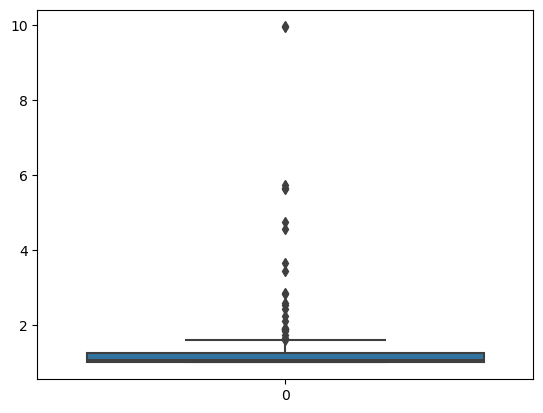

In [22]:
y_estimated_DS_10G = regr.predict(X_test_DS_10G)
print(f"Average Q-error for index filter model on TPC-DS 10G:\n{q_error(y_test_DS_10G, y_estimated_DS_10G)}")

results_DS_10G = [q_error([y_test_DS_10G[i]], [y_estimated_DS_10G[i]]) for i in range(len(y_test_DS_10G))]
sns.boxplot(sorted(results_DS_10G)[:int(0.99*len(results_DS_10G))])

Average Q-error for index filter model on TPC-DS 50G:
9.227629437760456


<Axes: >

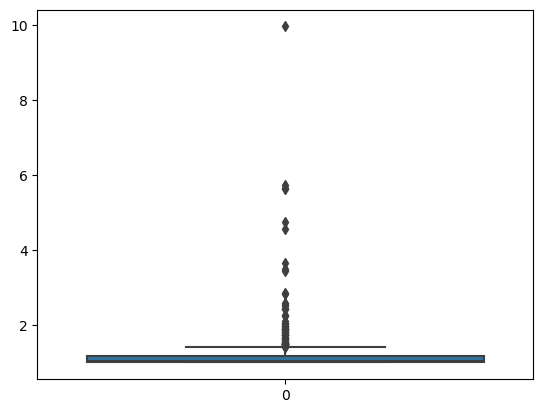

In [27]:
y_estimated_DS_50G = regr.predict(features_DS_50G_encoded)
print(f"Average Q-error for index filter model on TPC-DS 50G:\n{q_error(labels_DS_50G, y_estimated_DS_50G)}")

results_DS_50G = [q_error([labels_DS_50G[i]], [y_estimated_DS_50G[i]]) for i in range(len(labels_DS_50G))]
sns.boxplot(sorted(results_DS_50G)[:int(0.99*len(results_DS_50G))])

Average Q-error for index filter model on TPC-H:
4.098774814100743


<Axes: >

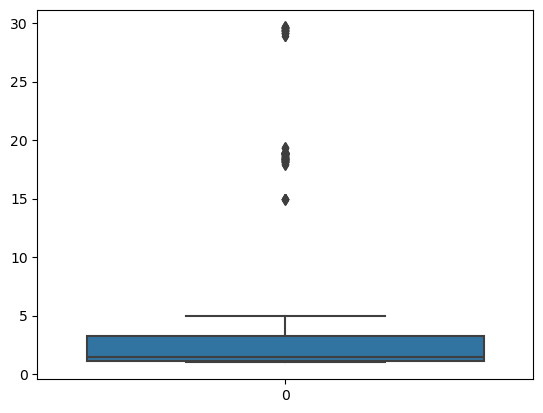

In [24]:
# regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_H, y_train_H)
y_estimated_H = regr.predict(features_H_encoded)
print(f"Average Q-error for index filter model on TPC-H:\n{q_error(labels_H, y_estimated_H)}")

results_H = [q_error([labels_H[i]], [y_estimated_H[i]]) for i in range(len(labels_H))]
sns.boxplot(sorted(results_H)[:int(0.99*len(results_H))])

### Index Cost Model

#### clustering

In [23]:
def group_data_by_template(data, template_range):
    templates = {entry[0].nr: [entry] for entry in data if entry[0].nr <= template_range}
    for entry in data:
        query = entry[0]
        if query.nr <= template_range: continue
        suffix = int(str(query.nr)[-2:])
        templates[suffix].append(entry)
    return templates

templates_DS_50G = group_data_by_template(DS_50G_data, 99)
templates_DS_10G = group_data_by_template(DS_10G_data, 99)
templates_H = group_data_by_template(H_data, 22)

In [24]:
print(f"{templates_H[4][0][0].nr}: {templates_H[4][0][0].text}")
print(f"{templates_H[4][1][0].nr}: {templates_H[4][1][0].text}")

4: -- Functional Query Definition
-- Approved February 1998


select
o_orderpriority,
count(*) as order_count
from
orders
where
o_orderdate >= date '1994-05-01'
and o_orderdate < date '1994-05-01' + interval '3' month
and exists (
select
*
from
lineitem
where
l_orderkey = o_orderkey
and l_commitdate < l_receiptdate
)
group by
o_orderpriority
order by
o_orderpriority ;
-- $ID$
-- TPC-H/TPC-R Local Supplier Volume 
104: -- Functional Query Definition
-- Approved February 1998


select
o_orderpriority,
count(*) as order_count
from
orders
where
o_orderdate >= date '1996-11-01'
and o_orderdate < date '1996-11-01' + interval '3' month
and exists (
select
*
from
lineitem
where
l_orderkey = o_orderkey
and l_commitdate < l_receiptdate
)
group by
o_orderpriority
order by
o_orderpriority ;
-- $ID$
-- TPC-H/TPC-R Local Supplier Volume 


In [25]:
import os

def get_parameters_for_tpcds(columns, template_id):
    root_path = "tpcds-kit/query_templates"
    filename = f"query{template_id}.tpl"
    params, variables = set(), []
    with open(os.path.join(root_path, filename)) as f:
        for line in f:
            line = line.strip()
            if "define" in line:
                variable = line.split(" ")[1].split("=")[0]
                if "LIMIT" in variable: continue
                if "text" in line:
                    for column in columns.values():
                            if column.name in line:
                                params.add(column)
                variables.append(variable)
            else:
                for var in variables:
                    if var in line:
                        for column in columns.values():
                            if column.name in line:
                                params.add(column)
    return list(params)

TPC_DS_50G_params = get_parameters_for_tpcds(column_dict_DS_50G, 3)
print(TPC_DS_50G_params)

[C store_sales.ss_ext_sales_price, C store_sales.ss_ext_discount_amt, C date_dim.d_moy, C item.i_manufact, C store_sales.ss_sales_price, C store_sales.ss_net_profit, C item.i_manufact_id]


In [26]:
def get_parameters_for_tpch(columns, template_id):
    root_path = "tpch-kit/dbgen/queries"
    filename = f"{template_id}.sql"
    params = set()
    with open(os.path.join(root_path, filename)) as f:
        for line in f:
            line = line.strip()
            if matched := re.search(r"\'?(%?:\d+%?)+\'?", line):
                for column in columns.values():
                    start = matched.span()[0]
                    if (pos := line.find(column.name)) != -1 and pos < start:      
                        params.add(column)    
    return params  
            
TPC_H_params = get_parameters_for_tpch(column_dict_H, 3)
print(TPC_H_params)

{C lineitem.l_shipdate, C orders.o_orderdate, C customer.c_mktsegment}


In [27]:
# feature 1
def calculate_parameter_selectivity(dataset_name, template_id, query_plan, column_dict):
    get_parameters = None
    if re.search("TPC_DS", dataset_name): get_parameters = get_parameters_for_tpcds
    elif re.search("TPCH", dataset_name): get_parameters = get_parameters_for_tpch
    else: raise ValueError("Not supported dataset")
    params = get_parameters(column_dict, template_id)
    selectivities = {param: 0 for param in params}
    _calculate_parameter_selectivity(params, selectivities, query_plan)
    return selectivities

def _calculate_parameter_selectivity(params, selectivities, query_plan):
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _calculate_parameter_selectivity(params, selectivities, child_node)
    if (condition := has_filtering_property(query_plan)) != "":
        for column in params:
            if column.name in condition:
                selectivities[column]= query_plan["Plan Rows"]/column.table.row_count

# feature 2
def evaluate_configuration(configuration, query_plan):
    configuration_features = {}
    _evaluate_configuration(configuration_features, configuration, query_plan)
    return configuration_features

def _evaluate_configuration(configuration_features, configuration, query_plan):
    current_operator = query_plan["Node Type"]
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _evaluate_configuration(configuration_features, configuration, child_node)
            
    if (condition := has_filtering_property(query_plan)) != "":
        for index in configuration:
            for j, column in enumerate(index.columns):
                if column.name in condition:
                    configuration_features[f"selectivity_{column.name}"] = query_plan["Plan Rows"]/column.table.row_count
                    feature = f"operation_{column.name}"
                    if feature not in configuration_features.keys(): configuration_features[feature] = set()
                    configuration_features[feature].add(current_operator)
                    feature = f"position_{column.name}"
                    if  feature not in configuration_features.keys(): configuration_features[feature] = j
                    else: configuration_features[feature] = min(configuration_features[feature], j)
    elif is_aggregate_operator(current_operator) and "Group Key" in query_plan.keys():
        conditions = query_plan["Group Key"]
        for index in configuration:
            for j, column in enumerate(index.columns):
                for condition in conditions:
                    if column.name in condition:
                        feature = f"operation_{column.name}"
                        if feature not in configuration_features.keys(): configuration_features[feature] = set()
                        configuration_features[feature].add(current_operator)
                        feature = f"position_{column.name}"
                        if  feature not in configuration_features.keys(): configuration_features[feature] = j
                        else: configuration_features[feature] = min(configuration_features[feature], j)
    elif is_sort_operator(current_operator) and "Sort Key" in query_plan:
        conditions = query_plan["Sort Key"]
        for index in configuration:
            for j, column in enumerate(index.columns):
                for condition in conditions:
                    if column.name in condition:
                        feature = f"order_{column.name}"
                        if "DESC" in condition: configuration_features[feature] = "DESC"
                        else: configuration_features[feature] = "ASC" # ascending by default
                        feature = f"position_{column.name}"
                        if  feature not in configuration_features.keys(): configuration_features[feature] = j
                        else: configuration_features[feature] = min(configuration_features[feature], j)

In [32]:
def construct_template_features_and_labels(dataset_name, templates, column_dict):
    template_feature_labels = {}
    for template_id, data in templates.items():
        labels = []
        get_parameters = None
        if re.search("TPC_DS", dataset_name): get_parameters = get_parameters_for_tpcds
        elif re.search("TPCH", dataset_name): get_parameters = get_parameters_for_tpch
        else: raise ValueError("Not supported dataset")
        params = get_parameters(column_dict, template_id)
        feature_columns = []
        param_selectivity_columns = [f"param_selectivity_{param.name}" for param in params]
        feature_columns.extend(param_selectivity_columns)
        config_selectivity_columns = list(set(f"selectivity_{column.name}" for entry in data for config in entry[1] for index in config for column in index.columns))
        feature_columns.extend(config_selectivity_columns)
        config_operation_columns = list(set(f"operation_{column.name}_{i}" for entry in data for config in entry[1] for index in config for column in index.columns for i in range(3)))
        feature_columns.extend(config_operation_columns)
        config_position_columns = list(set(f"position_{column.name}" for entry in data for config in entry[1] for index in config for column in index.columns))
        feature_columns.extend(config_position_columns)
        config_order_columns = list(set(f"order_{column.name}" for entry in data for config in entry[1] for index in config for column in index.columns))
        feature_columns.extend(config_order_columns)
        query_configs = [(entry[0], config) for entry in data for config in entry[1]]
        features = pd.DataFrame(columns=feature_columns, index=range(len(query_configs)))
        k = 0
        for i, entry in enumerate(data):
            query = entry[0]
            index_configs = entry[1]
            costs = entry[2]
            plans = entry[3]
            for j, (config, plan) in enumerate(zip(index_configs, plans)):
                labels.append(costs[j])
                selectivities = calculate_parameter_selectivity(dataset_name, template_id, plan, column_dict)
                for param, value in selectivities.items():
                    features.iloc[k][f"param_selectivity_{param.name}"] = value
                config_feature = evaluate_configuration(config, plan)
                for feature_name, value in config_feature.items():
                    if isinstance(value, set):
                        for l, operator in enumerate(list(value)):
                            features.iloc[k][f"{feature_name}_{l}"] = operator
                    else:
                        features.iloc[k][feature_name] = value
                k+=1
        features[param_selectivity_columns+config_selectivity_columns] = features[param_selectivity_columns+config_selectivity_columns].apply(pd.to_numeric)
        features[config_position_columns] = features[config_position_columns].fillna(value=len(config_position_columns))
        features[config_position_columns] = features[config_position_columns].astype('float32')
        features[config_selectivity_columns] = features[config_selectivity_columns].fillna(value=1)
        template_feature_labels[template_id] = (features,labels)
    return template_feature_labels

In [33]:
template_feature_labels_DS_50G = construct_template_features_and_labels("TPC_DS", templates_DS_50G, column_dict_DS_50G)
template_feature_labels_DS_10G = construct_template_features_and_labels("TPC_DS", templates_DS_10G, column_dict_DS_10G)
template_feature_labels_H = construct_template_features_and_labels("TPCH", templates_H, column_dict_H)
template_feature_labels_DS_50G[2][0]

,param_selectivity_d_year,selectivity_d_week_seq,selectivity_d_year,operation_d_year_1,operation_d_week_seq_1,operation_d_week_seq_0,operation_d_year_2,operation_d_year_0,operation_d_week_seq_2,position_d_week_seq,position_d_year,order_d_week_seq,order_d_year
0,0.004997,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
1,0.000000,0.000178,1.0,NaN,Hash Join,Aggregate,NaN,NaN,NaN,1.0,2.0,ASC,NaN
2,0.004997,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
3,0.000000,0.000178,1.0,NaN,Hash Join,Aggregate,NaN,NaN,NaN,1.0,2.0,ASC,NaN
4,0.004997,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
5,0.000000,0.000178,1.0,NaN,Hash Join,Aggregate,NaN,NaN,NaN,1.0,2.0,ASC,NaN
6,0.004997,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN
7,0.000000,0.000178,1.0,NaN,Hash Join,Aggregate,NaN,NaN,NaN,1.0,2.0,ASC,NaN


#### Modeling

##### Random Forest

In [34]:
def template_feature_modeling_and_prediction(template_feature_labels):
    template_regressors, results = {}, {}
    for template_id, (features, labels) in template_feature_labels.items():
        # convert to one-hot
        features_encoded = to_onehot_encoding(features)

        X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels, test_size=0.33, random_state=2024)
        template_regressors[template_id] = RandomForestRegressor(n_estimators=5, max_depth=6, random_state=0).fit(X_train, y_train)
        y_estimated = template_regressors[template_id].predict(X_test)
        error = q_error(y_test, y_estimated)
        results[template_id] = error
        
    results = sorted(list(results.values()))
    avg_all_templates = sum(results[:int(0.99*len(results))])/len(results[:int(0.99*len(results))])
    print(f"Average Q-error for all templates (99 percentile): {avg_all_templates}")
    return template_regressors, results
    
_, results_DS_50G = template_feature_modeling_and_prediction(template_feature_labels_DS_50G)
_, results_DS_10G = template_feature_modeling_and_prediction(template_feature_labels_DS_10G)
_, results_H = template_feature_modeling_and_prediction(template_feature_labels_H)

Average Q-error for all templates (99 percentile): 1.935371973430574
Average Q-error for all templates (99 percentile): 1.819667263997852
Average Q-error for all templates (99 percentile): 1.05200219422386


<Axes: >

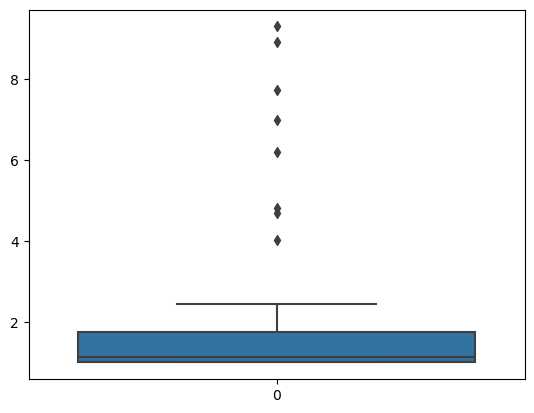

In [35]:
sns.boxplot(results_DS_50G[:int(0.99*len(results_DS_50G))])

<Axes: >

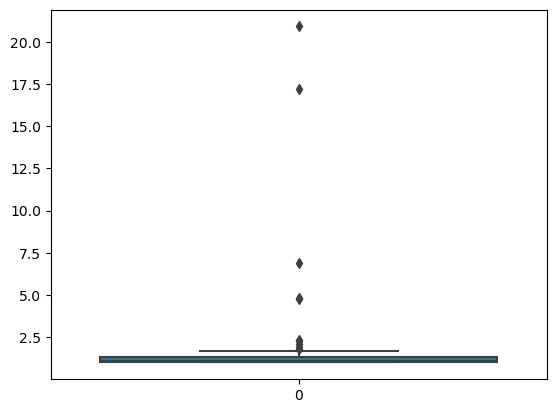

In [36]:
sns.boxplot(results_DS_10G[:int(0.99*len(results_DS_10G))])

<Axes: >

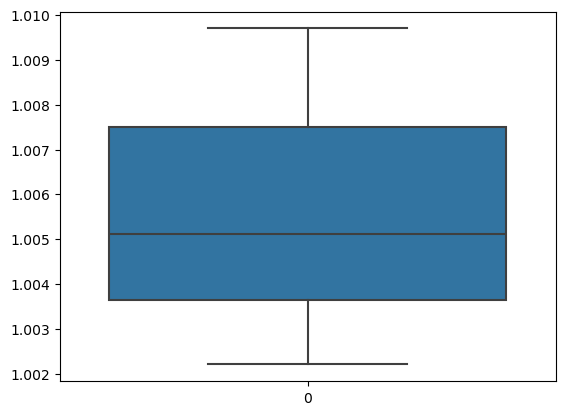

In [37]:
sns.boxplot(results_DS_10G[:int(0.99*len(results_H))])

### combined

In [25]:
total_sample_count, max_config_len = 0, 0
for entry in ds_data:
    total_sample_count += len(entry[1])-1
    for index_config in entry[1]:
        max_config_len = max(max_config_len, len(index_config))
print(max_config_len)
print(total_sample_count)


4
4526


In [23]:
labels = []
feature_columns = []
feature_columns.extend([f"utility_of_index{i}" for i in range(max_config_len)])
feature_columns.extend([f"num_pages_for_index{i}" for i in range(max_config_len)])
feature_columns.extend([f"use_bitmap_for_index{i}" for i in range(max_config_len)])
operator_relevance_columns = [f"relevance_{operator}_on_index{i}" for i in range(max_config_len) for operator in LOGICAL_OPERATORS]
feature_columns.extend(operator_relevance_columns)
query_shape_columns = [f"index{j}_query_shape_operator{i}_on_{table.name}" for j in range(max_config_len) for table in table_dict.values() for i in range(5)]
feature_columns.extend(query_shape_columns)
index_shape_columns = [f"index{j}_shape_operator{i}" for j in range(max_config_len) for i in range(5)]
feature_columns.extend(index_shape_columns)

features = pd.DataFrame(columns=feature_columns, index=range(total_sample_count))

k = 0
for entry in ds_data:
    query = entry[0]
    index_configs = entry[1]
    costs = entry[2]
    plans = entry[3]
    
    original_query_plan = plans[0] # no index query plan
    original_query_cost = costs[0] # no index query cost
    for i, index_config in enumerate(index_configs):
        labels.append(costs[i])
        indexed_query_plan = plans[i]
        for j, index in enumerate(index_config):
            utility = estimate_index_utility(index, original_query_plan, indexed_query_plan)/original_query_cost
            features.iloc[k][f"utility_of_index{j}"] = utility
            query_shape, index_shape = extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan)
            for table, operator_seq in query_shape.items():
                for o, operator in enumerate(operator_seq):
                    features.iloc[k][f"query_shape_operator{o}_on_{table}"] = operator
            for o, operator in enumerate(index_shape):
                features.iloc[k][f"index_shape_operator{o}"] = operator
            relevance = evaluate_operator_relevance(index, original_query_plan)
            for operator in LOGICAL_OPERATORS:
                if operator in relevance: features.iloc[k][f"relevance_{operator}_on_index{j}"] = sum(relevance[operator])/len(relevance[operator])
                else: features.iloc[k][f"relevance_{operator}_on_index{j}"] = 0
            features.iloc[k][f"num_pages_for_index{i}"] = get_number_of_pages(indexed_query_plan)
            features.iloc[k][f"use_bitmap_for_index{i}" ] = int(check_bitmap(indexed_query_plan))
        k+=1
    
features[["utility", "num_pages"]+operator_relevance_columns] = features[["utility", "num_pages"]+operator_relevance_columns].apply(pd.to_numeric)
features["use_bitmap"] = features["use_bitmap"].astype('int')

print("labels:\n", labels)
features


NameError: name 'index_config' is not defined